In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import random
from utils import *
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Here I start the implementation

Hyperparameter of implementation

In [3]:
anchor_probability_numerator = 20
notifications = 2
epsilon = 0.2
deletion_prob_at_each_step = 0.2
num_samples_for_agreement_and_heavyness_calculation = 2
num_samples_for_connect_procedure = 2

 I am breakiiiing for you baby
Oh now, the graph is empty
 agreement = 0.9195804225324155 vs pivot = 1.0853384237335935 vs singleton = 1.0
agreement time = 2.1553525924682617 vs pivot total time = 0.09725809097290039
agreement worst update time = 0.05064678192138672 vs pivot worst update time = 2.6941299438476562e-05
agreement time for additions = 1.5392870903015137
agreement worst update time for additions = 0.050647735595703125
agreement time for deletions = 0.6222631931304932
agreement worst update time for deletions = 0.0014679431915283203
 I am breakiiiing for you baby
Oh now, the graph is empty
 agreement = 0.9132459091642126 vs pivot = 1.044905166260699 vs singleton = 1.0
agreement time = 2.5778658390045166 vs pivot total time = 0.11106157302856445
agreement worst update time = 0.06955790519714355 vs pivot worst update time = 2.6702880859375e-05
agreement time for additions = 2.042609691619873
agreement worst update time for additions = 0.06955790519714355
agreement time for del

KeyboardInterrupt: 

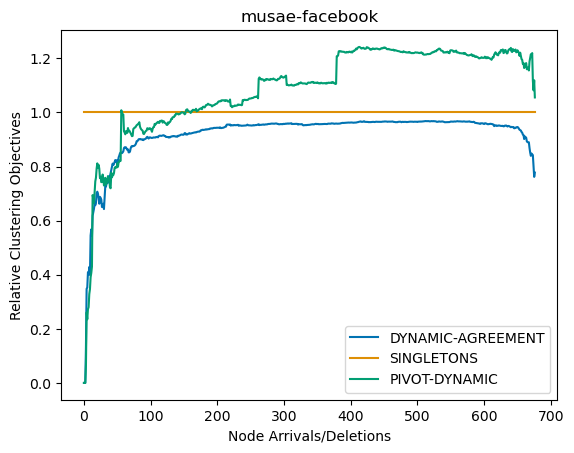

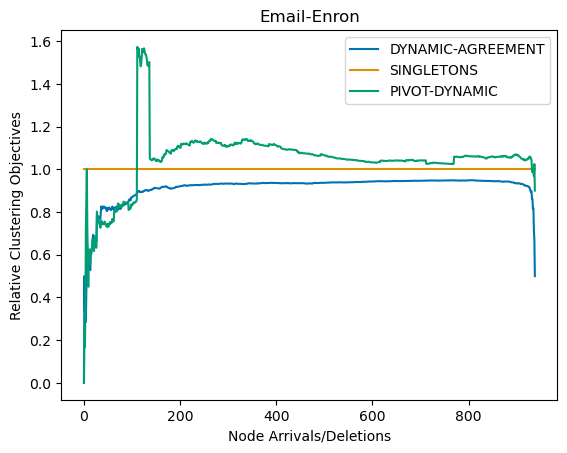

In [4]:
# Set Seaborn color palette for color-blind friendly colors
sns.set_palette("colorblind")
datasets =  ["datasets/musae-facebook.csv",  "datasets/Email-Enron.csv", "datasets/Cit-HepTh.csv", "datasets/CA-AstroPh.csv"]

# datasets =  ["datasets/Cit-HepTh.csv"]
# datasets =  ["datasets/Email-Enron.csv"]
# datasets =  ["datasets/CA-AstroPh.csv"]
# datasets =  ["datasets/musae-facebook.csv"]


num_experiments = 1
for csv_file_path in datasets:
    # Create lists to store objective values for each dataset
    correlation_values_clustering = []
    correlation_values_all_singletons = []
    correlation_values_pivot_clustering = []
    graph_adjacency_lists = create_graph_from_csv(csv_file_path)
    # Generate a random node arrival order
    random_node_order = generate_random_node_order(graph_adjacency_lists)

    # Initialization for the random variables of dynamic pivot
    # we first contract a random permulation pi: node --> order in the random permulation
    pi = {element: index for index, element in enumerate(generate_random_node_order(graph_adjacency_lists))}
    eta = {key: key for key in pi.keys()}
    pivot_clustering = {key: key for key in pi.keys()}

    #Initializaiton for the random variables of agreement
    sparse_graph = {}
    nodes_present_at_the_moment = OptList()
    Phi = set()
    Phi_nodes = {}
    I_nodes = defaultdict(set)
    B_nodes = {node:OptList() for node in graph_adjacency_lists}


    # this it to measure the time in each execution
    dynamic_pivot_total_time = .0
    agreement_total_time = .0
    dynamic_pivot_worst_update_time = .0
    agreement_worst_update_time = .0

    agreement_total_time_node_additions = .0
    agreement_total_time_node_deletions = .0

    agreement_worst_update_time_node_additions = .0
    agreement_worst_update_time_node_deletions = .0



    # Initialize an empty dictionary to store the current graph
    current_graph = {}
    # p is the probabilty of a random deletion at each time step
    random_node_iterator = iter(random_node_order)
    i = -1
    only_deletion = False

    total_iterations = 2* len(graph_adjacency_lists)
    #### Here starts the copy paste

    while True:
#         if i > 1000:
#             break
        
        i +=1
        if (i > 100) and (not current_graph):
            print("Oh now, the graph is empty")
            break
        if ((random.random() < deletion_prob_at_each_step) and (i > 0) and current_graph) or (only_deletion and current_graph):
            deletion = True
            # node deletion
            node = nodes_present_at_the_moment.getRandom()
            neighbors_to_delete = [neighbor for neighbor in current_graph[node]]
            start_time = time.time()
            for neighbor in neighbors_to_delete:
                if not current_graph[neighbor].remove(node):
                    print("We have a problem Houston")
                if node == neighbor:
                    continue
                # start timer for pivot
                # we now update the pivot clustering
                if (eta[neighbor] != node) or (eta[node] != neighbor):
                    # no need for update in this case
                    continue
                # when node may have been the pivot of neighbor
                if eta[neighbor] == node:
                    eta[neighbor] = neighbor
                    for neighbor_of_neighbor in current_graph[neighbor]:
                        if pi[neighbor_of_neighbor] < pi[eta[neighbor]]:
                            eta[neighbor] = neighbor_of_neighbor
                    if eta[neighbor] == neighbor:
                        pivot_clustering[neighbor] = neighbor
                        for neighbor_of_neighbor in current_graph[neighbor]:
                            if neighbor_of_neighbor == neighbor:
                                continue
                            pivot_clustering[neighbor_of_neighbor] = neighbor if eta[neighbor_of_neighbor] == neighbor else pivot_clustering[neighbor_of_neighbor]
                    else:
                        pivot_clustering[neighbor] = eta[neighbor] if eta[neighbor] == eta[eta[neighbor]] else neighbor
                # when eta[node] == neighbor. This neighbor may have been the pivot of node
                else:
                    eta[node] = node
                    for neighbor_of_neighbor in current_graph[node]:
                        if pi[neighbor_of_neighbor] < pi[eta[node]]:
                            eta[node] = neighbor_of_neighbor
                    if eta[node] == node:
                        pivot_clustering[node] = node
                        for neighbor_of_neighbor in current_graph[node]:
                            if neighbor_of_neighbor == node:
                                continue
                            pivot_clustering[neighbor_of_neighbor] = node if eta[neighbor_of_neighbor] == node else pivot_clustering[neighbor_of_neighbor]
                    else:
                        pivot_clustering[node] = eta[node] if eta[node] == eta[eta[node]] else node
                dynamic_pivot_total_time += (time.time() - start_time)
                dynamic_pivot_worst_update_time = max(dynamic_pivot_worst_update_time, time.time() - start_time)

            nodes_present_at_the_moment.remove(node)

            del current_graph[node]
        else:
            deletion = False
            try:
                # node addition
                node = next(random_node_iterator)
            except StopIteration:
                # StopIteration is raised when the iterator is exhausted
                print(" I am breakiiiing for you baby")
                only_deletion = True
                continue
            current_graph[node] = OptList()
            nodes_present_at_the_moment.append(node)
            # Add edges to previously arrived nodes
            for neighbor in graph_adjacency_lists[node]:
                if neighbor in nodes_present_at_the_moment:
                    # I have to update the pivot clustering
                    start_time = time.time()
                    # this is the case where node may become the new pivot of neighbor
                    if pi[eta[neighbor]] > pi[node]:
                        if eta[neighbor] == neighbor:
                            for w in current_graph[neighbor]:
                                if w == neighbor:
                                    continue
                                pivot_clustering[w] = w if eta[w]==neighbor else pivot_clustering[w]
                        eta[neighbor] = node
                        pivot_clustering[neighbor] = node if eta[node]==node else neighbor

                    if pi[eta[node]] > pi[neighbor]:
                        if eta[node] == node:
                            for w in current_graph[node]:
                                if w == node:
                                    continue
                                pivot_clustering[w] = w if eta[w]==node else pivot_clustering[w]
                        eta[node] = neighbor
                        pivot_clustering[node] = neighbor if eta[neighbor]==neighbor else node
                    dynamic_pivot_total_time += (time.time() - start_time)
                    dynamic_pivot_worst_update_time = max(dynamic_pivot_worst_update_time, time.time() - start_time)
                    current_graph[neighbor].append(node)
                    current_graph[node].append(neighbor)




    #         if nodes_present_at_the_moment != set(current_graph.keys()):
    #             print("oups")
            # Here we start the series of updates to maintain my sparse solution
            # Note that the Notify procedure is the only one where it actually matter to know if a node
            # was deleted or not
            # --------------------------------------Notify--------------------------------------

            # ---------send Type 0 notifications-------------------
        start_time = time.time()
        #print(node)
        notified_so_far = set()
        if deletion:
            # check if I also need to delete my presence from all Ivs, it should not be the case
            # delete its presence from all B_v
            for v in I_nodes[node]:
                if v == node:
                    print("We may have a problem Houston")
                B_nodes[v].remove(node)
            #if not B_nodes[node]:
            #    print(f"why the backward set of: {node} does not exist")
            got_type_0_notification = B_nodes[node].getRandom(notifications)
            # There is no need for that deletion
    #         if B_nodes[node]:
    #             for v in B_nodes[node]:
    #                 I_nodes[v].remove(node)
    #         del B_nodes[node]
            # we need to remove node, from any forward notification set
            if not got_type_0_notification:
                #print("oups")
                continue
            got_type_0_notification.discard(node)
            if not got_type_0_notification:
                continue
        else:
            notified_so_far.add(node)
            got_type_0_notification = current_graph[node].getRandom(notifications)
            if got_type_0_notification:
                got_type_0_notification.discard(node)
                I_nodes[node].update(got_type_0_notification)
                for v in got_type_0_notification:
                    B_nodes[v].append(node)

        # ---------send Type 1 notifications-------------------
        got_type_1_notification = set()
        for v in got_type_0_notification:
            if v not in current_graph:
                continue
            # this is to avoid that the notification graph becomes too dense
            for u in I_nodes[v]:
                B_nodes[u].remove(v)
            # take another sample 1
            #del I_nodes[v]
            br = current_graph[v].getRandom(notifications)
            I_nodes[v].update(current_graph[v].getRandom(notifications))
            I_nodes[v].discard(v)
            I_nodes[v].discard(node)
            for u in I_nodes[v]:
                B_nodes[u].append(v)
                if u not in notified_so_far:
                    got_type_1_notification.add(u)
                    notified_so_far.add(u)

        # ---------send Type 2 notifications-------------------
        got_type_2_notification = set()
        for v in got_type_1_notification:
            if v not in current_graph:
                continue
            for u in I_nodes[v]:
                B_nodes[u].remove(v)
            # take another sample 2
            #del I_nodes[v]
            br = current_graph[v].getRandom(notifications)
            I_nodes[v].update(current_graph[v].getRandom(notifications))
            I_nodes[v].discard(v)
            I_nodes[v].discard(node)
            for u in I_nodes[v]:
                B_nodes[u].append(v)
                if (u not in notified_so_far) or (u not in got_type_2_notification) :
                    got_type_2_notification.add(u)

        # ---------receive Type 2 notifications-------------------
        for v in got_type_2_notification:
            if v not in current_graph:
                continue
            # just update the sample
            for u in I_nodes[v]:
                B_nodes[u].remove(v)
            I_nodes[v] = current_graph[v].getRandom(notifications)
            I_nodes[v].discard(v)
            I_nodes[v].discard(node)
            for u in I_nodes[v]:
                B_nodes[u].append(v)

        #first we check if it is a deletion or addition and initialize the respective
        # variables
        if not deletion:
            sparse_graph[node] = OptList()
            Phi_nodes[node] = set()
        else:
            Phi.discard(node)
            neighbors_to_delete = [neighbor for neighbor in sparse_graph[node]]
            for neighbor in neighbors_to_delete:
                sparse_graph[neighbor].remove(node)
                sparse_graph[node].remove(neighbor)
                Phi_nodes[neighbor].discard(node)
            del sparse_graph[node]
            del Phi_nodes[node]


        # The interesting event set corresponds to the notified_so_far
        for u in notified_so_far:
            if deletion and node == u:
                continue
            if u not in nodes_present_at_the_moment:
                continue
                print("Another problem")
            # if u is in Phi we first delete all its edges to nodes not in Phi
            if u in Phi:
                neighbors_of_u = [v for v in sparse_graph[u]]
                for v in neighbors_of_u:
                    if (u == v) or (v in Phi):
                        continue
                    sparse_graph[u].remove(v)
                    sparse_graph[v].remove(u)
                    Phi_nodes[v].discard(u)
            Phi.discard(u)
            # we now implement the Anchor procedure
            anchor_prob = anchor_probability_numerator / len(current_graph[u])
            if (random.random() < anchor_prob) and ProbAHeaviness(u, current_graph, epsilon, num_samples_for_agreement_and_heavyness_calculation):
                Phi.add(u)
                for v in current_graph[u]:
                    if ProbAgreement(u, v, current_graph, epsilon, num_samples_for_agreement_and_heavyness_calculation):
                        sparse_graph[u].append(v)
                        sparse_graph[v].append(u)
                        if u != v:
                            Phi_nodes[v].add(u)


            # Now we implement the Clean procedure
            connected_nodes_in_anchor_set = [w for w in Phi_nodes[u]]
            for w in connected_nodes_in_anchor_set:
                if w not in nodes_present_at_the_moment:
                    Phi_nodes[u].discard(w)
                    #del sparse_graph[w]
                    continue
    #                     print(sparse_graph[w])
    #                     if w in sparse_graph[u]:
    #                         print("Maybe the problem is biggest that we thought")
    #                         print(Phi_nodes[w])
                #break
                if w == u:
                    continue
                if ProbAgreement(u, w, current_graph, epsilon, num_samples_for_agreement_and_heavyness_calculation) and ProbAHeaviness(w, current_graph, epsilon, num_samples_for_agreement_and_heavyness_calculation):
                    continue
                else:
                    sparse_graph[u].remove(w)
                    sparse_graph[w].remove(u)
                    Phi_nodes[u].discard(w)

            # Now we implement the Connect procedure
            J_u = current_graph[u].getRandom(num_samples_for_connect_procedure)
            for w in J_u:
                phi_nodes_w = [r for r in Phi_nodes[w]]
                for r in phi_nodes_w:
                    if r not in nodes_present_at_the_moment:
                        Phi_nodes[w].discard(r)
                        continue
                    if r not in current_graph[u]:
                        continue
                    if ProbAgreement(u, r, current_graph, epsilon, num_samples_for_agreement_and_heavyness_calculation) and ProbAHeaviness(r, current_graph, epsilon, num_samples_for_agreement_and_heavyness_calculation):
                        sparse_graph[u].append(r)
                        sparse_graph[r].append(u)
                        Phi_nodes[u].add(r)
        agreement_total_time+=(time.time() - start_time)
        agreement_worst_update_time = max(agreement_worst_update_time, time.time() - start_time)
        if deletion:
            agreement_total_time_node_deletions+=(time.time() - start_time)
            agreement_worst_update_time_node_deletions = max(agreement_worst_update_time_node_deletions, time.time() - start_time)
        else:
            agreement_total_time_node_additions+=(time.time() - start_time)
            agreement_worst_update_time_node_additions = max(agreement_worst_update_time_node_additions, time.time() - start_time)
        if agreement_worst_update_time > 20.5:
            print(f"Deletion = {deletion}")
        if (i+1) % 50 == 0:
            clustering = connected_components(sparse_graph)
            all_singletons = {element: index for index, element in enumerate(sparse_graph.keys())}
            pivot_clustering_this_step = {u: pivot_clustering[u] for u in sparse_graph.keys()}

            # Calculate correlation values and store them
            corr_clustering = correlation_clustering_value(current_graph, clustering)
            corr_all_singletons = correlation_clustering_value(current_graph, all_singletons)
            corr_pivot_clustering = correlation_clustering_value(current_graph, pivot_clustering_this_step)
            if corr_all_singletons != 0:
                correlation_values_clustering.append(corr_clustering/corr_all_singletons)
                correlation_values_all_singletons.append(corr_all_singletons/corr_all_singletons)
                correlation_values_pivot_clustering.append(corr_pivot_clustering/corr_all_singletons)

    plt.figure()
    # Plot the results
    plt.plot(correlation_values_clustering, label='DYNAMIC-AGREEMENT')
    plt.plot(correlation_values_all_singletons, label='SINGLETONS')
    plt.plot(correlation_values_pivot_clustering, label='PIVOT-DYNAMIC')
    dataset_name = csv_file_path.split("/")[-1].replace('.csv', '')
    plt.title(f'{dataset_name}')

    plt.xlabel('Node Arrivals/Deletions')
    plt.ylabel('Relative Clustering Objectives')
    plt.legend()
    plt.savefig(f"{dataset_name}.pdf", format="pdf")


        # Plot the results
    print(f" agreement = {np.mean(correlation_values_clustering)} vs pivot = "
      f"{np.mean(correlation_values_pivot_clustering)} vs singleton = {np.mean(correlation_values_all_singletons)}")


    # plt.show()                         
    print(f"agreement time = {agreement_total_time/float(num_experiments)} vs pivot total time = {dynamic_pivot_total_time/float(num_experiments)}")
    print(f"agreement worst update time = {agreement_worst_update_time} vs pivot worst update time = {dynamic_pivot_worst_update_time}")

    print(f"agreement time for additions = {agreement_total_time_node_additions/float(num_experiments)}")
    print(f"agreement worst update time for additions = {agreement_worst_update_time_node_additions}")

    print(f"agreement time for deletions = {agreement_total_time_node_deletions/float(num_experiments)}")
    print(f"agreement worst update time for deletions = {agreement_worst_update_time_node_deletions}")

    print("=========================================================================================================")
